In [ ]:
!pip install keras-self-attention


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=1ee4367fd55876f8522a23c87b8ea63b5674e5affa23c8ee26065780eb86f1e0
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/glove.6B.zip"

Archive:  /content/drive/MyDrive/glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [2]:
import tensorflow as tf
from tensorflow.keras import layers


class ShuffleAttention(tf.keras.layers.Layer):

    def _init_(self, channel=512, reduction=16, G=8):
        super(ShuffleAttention, self)._init_()
        self.G = G
        self.channel = channel
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.gn = layers.LayerNormalization(axis=-1)
        self.cweight = self.add_weight(shape=(1, 1, 1, channel // (2 * G)), initializer='zeros', trainable=True, name='cweight')
        self.cbias = self.add_weight(shape=(1, 1, 1, channel // (2 * G)), initializer='ones', trainable=True, name='cbias')
        self.sweight = self.add_weight(shape=(1, 1, 1, channel // (2 * G)), initializer='zeros', trainable=True, name='sweight')
        self.sbias = self.add_weight(shape=(1, 1, 1, channel // (2 * G)), initializer='ones', trainable=True, name='sbias')
        self.sigmoid = layers.Activation('sigmoid')

    def channel_shuffle(x, groups):
        b, c, h, w = x.shape.as_list()
        x = tf.reshape(x, (b, groups, -1, h, w))
        x=tf.keras.layers.permute((0,2,1,3,4))(x)
        # flatten
        x = tf.reshape(x, (b, -1, h, w))

        return x
def call(self, inputs):
    b, h, w, c = inputs.shape.as_list()

    channels_per_group = c // (2 * self.G)

    cweight = tf.reshape(self.cweight, (1, 1, 1, channels_per_group))
    cbias = tf.reshape(self.cbias, (1, 1, 1, channels_per_group))

    x = tf.reshape(inputs, (b * self.G, -1, h, w))

    x_0, x_1 = tf.split(x, num_or_size_splits=2, axis=1)

    x_channel = self.avg_pool(x_0)
    x_channel = cweight * x_channel + cbias
    x_channel = x_0 * self.sigmoid(x_channel)

    x_spatial = self.gn(x_1)
    x_spatial = self.sweight * x_spatial + self.sbias
    x_spatial = x_1 * self.sigmoid(x_spatial)

    out = tf.concat([x_channel, x_spatial], axis=1)
    out = self.channel_shuffle(out, 2)


    return out


In [7]:
def readGloveFile(gloveFile, max_vocab_size):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  # map from a token to a Glove embedding vector
        wordToIndex = {}  # map from a token to an index
        indexToWord = {}  # map from an index to a token

        for idx, line in enumerate(f):
            if idx >= max_vocab_size:
                break
            record = line.strip().split()
            token = record[0]
            wordToGlove[token] = np.array(record[1:], dtype=np.float64)

        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1
            wordToIndex[tok] = kerasIdx # associate an index to a token .
            indexToWord[kerasIdx] = tok # associate a word to a token .

    return wordToIndex, indexToWord, wordToGlove

# Create Pretrained Keras Embedding Layer
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable,vocab_size):
    vocabLen =  vocab_size+1
    embDim = next(iter(wordToGlove.values())).shape[0]

    embeddingMatrix = np.zeros((vocabLen, embDim))  # initialize with zeros
    for word, index in wordToIndex.items():
        if index < vocab_size+1:
            embeddingMatrix[index, :] = wordToGlove[word] # create embedding: word index to Glove word embedding
    print(f'\n\n\n vocabLen {vocabLen}\n\n embDim {embDim}\n\n\n')
    embeddingLayer = Embedding(vocabLen, embDim, weights=[embeddingMatrix], trainable=isTrainable)
    return embeddingLayer
# Code is from this stack overflow article --
# https://stackoverflow.com/questions/48677077/how-do-i-create-a-keras-embedding-layer-from-a-pre-trained-word-embedding-datase

In [4]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, Conv1D, GlobalMaxPooling1D, Attention, Conv2D,UpSampling2D,AveragePooling2D,GlobalAveragePooling2D,Dropout
import numpy as np
import tensorflow as tf
def create_deep_learning_model(vocab_size, max_sequence_length, embedding_dim, num_filters, kernel_sizes, lstm_units, attention_units,upsampling_factors):
    input_layer = Input(shape=(max_sequence_length,))

    # embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    wordToIndex, indexToWord, wordToGlove = readGloveFile("/content/drive/MyDrive/new/glove.6B.200d.txt",vocab_size)
    pretrainedEmbeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, False,vocab_size)

    # Embedding layer
    embedding_layer = pretrainedEmbeddingLayer(input_layer)
    lstm_layer1 = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding_layer)
    lstm_layer = Dropout(rate=0.75)(lstm_layer1)

    # Self-attention layer
    query_dense1 = Dense(units=attention_units)(lstm_layer)
    query_dense = Dropout(rate=0.75)(query_dense1)

    key_dense1 = Dense(units=attention_units)(lstm_layer)
    key_dense = Dropout(rate=0.75)(key_dense1)

    value_dense1 = Dense(units=attention_units)(lstm_layer)
    value_dense = Dropout(rate=0.75)(value_dense1)


    # query = query_dense(lstm_layer)
    # key = key_dense(lstm_layer)
    # value = value_dense(lstm_layer)

    attention_scores = Attention(dropout=0.5)([query_dense, key_dense,value_dense])

    attention_output = attention_scores

    cnn_outputs = []
    for kernel_size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size,padding='same')(attention_output)
        cnn_outputs.append(conv_layer)

    # print(len(cnn_outputs[0]))
    concatenated_output = tf.stack(cnn_outputs,axis=-1)
    # Conv2D layers
    conv2d_lay_1 = Conv2D(filters=num_filters, kernel_size=7, padding='same')(concatenated_output)
    upsample_1 = UpSampling2D(size=upsampling_factors[0])(conv2d_lay_1)

    conv2d_lay_2 = Conv2D(filters=num_filters/2, kernel_size=5, padding='same')(conv2d_lay_1)
    upsample_2 = UpSampling2D(size=upsampling_factors[1])(conv2d_lay_2)

    conv2d_lay_3 = Conv2D(filters=num_filters/4, kernel_size=3, padding='same')(conv2d_lay_2)
    upsample_3 = UpSampling2D(size=upsampling_factors[2])(conv2d_lay_3)

    conv2d_lay_4 = Conv2D(filters=num_filters/8, kernel_size=3, padding='same')(conv2d_lay_3)
    upsample_4 = UpSampling2D(size=upsampling_factors[3])(conv2d_lay_4)

    # Concatenate all upsamples
    concatenated_upsamples = Concatenate()([upsample_1, upsample_2, upsample_3, upsample_4])

    # Shuffle layer
    sa_layer = ShuffleAttention()
    shuffle_output = sa_layer(concatenated_upsamples)

    avg_pooled1=AveragePooling2D(pool_size=3)(shuffle_output)

    dense_out_drop = Dense(units=64)(avg_pooled1)
    dense_out1 = Dropout(0.5)(dense_out_drop)

    # avg_pooled2=AveragePooling2D(pool_size=3)(dense_out1)

    # dense_out_drop1 = Dense(units=32)(avg_pooled2)
    # dense_out = Dropout(0.5)(dense_out_drop1)

    avg_pooled=GlobalAveragePooling2D()(dense_out1)

    # Output layer
    output_layer = Dense(units=1, activation='sigmoid')(avg_pooled)



    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [6]:
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
vocab_size = 10000
max_sequence_length = 200
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
up_fc = [(1, 1), (1, 1), (1, 1), (1, 1)]  # Upsampling factors for each Conv2D layer (you need to decide these)

x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

model = create_deep_learning_model(vocab_size, max_sequence_length, embedding_dim=200, num_filters=128, kernel_sizes=[5, 6, 9], lstm_units=32, attention_units=64,upsampling_factors=up_fc)
model.summary()
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model

# history=model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_test, y_test))





 vocabLen 10001

 embDim 200



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 200, 200)             2000200   ['input_2[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 200, 64)              59648     ['embedding_1[0][0]']         
 onal)                                                                                            
                                                                                                  
 dropout_5 (Dropout)         (None, 200, 64)             

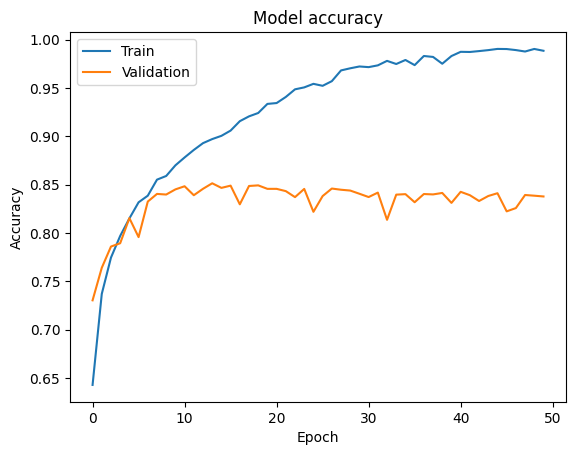

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


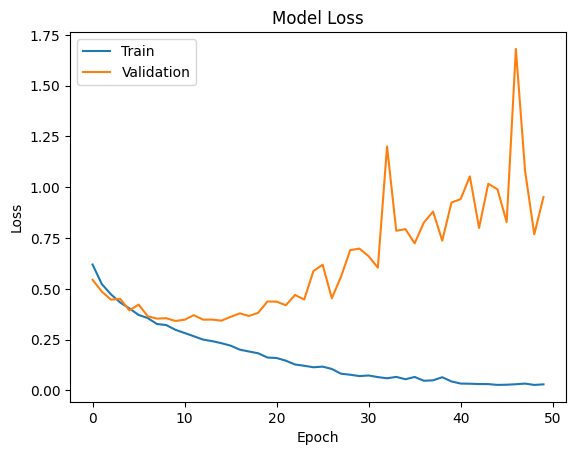

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()